In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/bartek/Workspace/models/research')
sys.path.append('/home/bartek/Workspace/models/research/slim')

In [25]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from object_detection.utils import dataset_util

import cv2
import numpy as np
from PIL import Image
from collections import namedtuple
import xml.etree.ElementTree as ET
import pandas as pd
import random
import os
import io

Show some images
-------------------

In [4]:
def get_images(dir_path, n=16):
    files = os.listdir(dir_path)
    files = random.sample(files, n)
    full_paths = [plt.imread(os.path.join(dir_path, f_name)) for f_name in files]
    return full_paths


def show_images(images, columns=4, rows=4):
    assert rows*columns == len(images)
    
    fig, ax = plt.subplots(rows, columns, figsize=(12, 6))

    for plot_num, image in enumerate(images):
        i, j = plot_num // columns, plot_num % columns
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        ax[i,j].cla()
        ax[i,j].imshow(image)

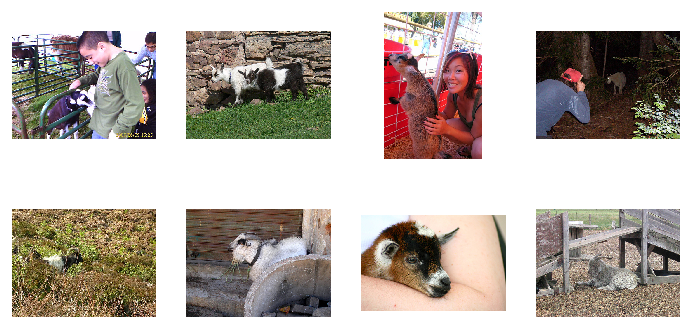

In [5]:
images = get_images('data/train_images', n=8)
show_images(images, 4, 2)

Create csv files containing labels
----------------------------------

In [6]:
def get_labels_from_xml(label_file):
    all_labels = []

    tree = ET.parse(label_file)
    root = tree.getroot()
    img_file = root.find('filename').text
    img_path = root.find('path').text
    size = root.find('size')
    height = int(size.find('height').text)
    width = int(size.find('width').text)

    for obj in root.findall('object'):
        label_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)

        all_labels.append((img_file, img_path, width, height, label_name,
                           xmin, ymin, xmax, ymax))

    return all_labels


def get_labels_from_dir(labels_dir):
    all_labels = []
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.xml'):
            continue

        all_labels += get_labels_from_xml(os.path.join(labels_dir, label_file))
    return all_labels


def convert_to_csv(labels):
    columns = ['filename', 'path', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(labels, columns=columns)
    return df

In [7]:
for labels_dir in ['data/train_labels', 'data/eval_labels']:
    labels = get_labels_from_dir(labels_dir)
    labels = convert_to_csv(labels)
    labels.to_csv(os.path.join(labels_dir, 'labels.csv'))

labels.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
0,101.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,375,goat,94,36,402,277
1,271.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,375,goat,126,163,255,269
2,276.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,400,goat,138,101,327,400
3,28.jpg,/home/bartek/Workspace/goats/data/eval_images/...,350,366,goat,51,4,335,315
4,287.jpg,/home/bartek/Workspace/goats/data/eval_images/...,500,455,goat,351,213,452,398


Convert csv labels to TFRecord File Format
-------------------------------------------------

In [8]:
def class_to_id(class_text):
    if class_text == 'goat':
        return 1

    
def split_by_filename(df, group):
    data = namedtuple('data', [group, 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]
    

def create_tf_example(group):
    with tf.gfile.GFile(group.path, 'rb') as fid:
        encoded_jpg = fid.read()

    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.path.split('/')[-1].encode('utf8')

    image_format = b'jpeg'
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for i, data in group.object.iterrows():
        xmins.append(data['xmin'] / width)
        xmaxs.append(data['xmax'] / width)

        ymins.append(data['ymin'] / height)
        ymaxs.append(data['ymax'] / height)

        class_text = data['class']
        classes_text.append(class_text.encode('utf8'))
        classes.append(class_to_id(class_text))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def create_tfrecord(csv_path, output_path):
    writer = tf.python_io.TFRecordWriter(output_path)
    examples = pd.read_csv(csv_path)
    grouped = split_by_filename(examples, 'path')

    for group in grouped:
        tf_example = create_tf_example(group)
        writer.write(tf_example.SerializeToString())

    writer.close()

In [9]:
csv_paths = ['data/train_labels/labels.csv', 'data/eval_labels/labels.csv']
output_paths = ['data/train.record', 'data/eval.record']

for csv, output in zip(csv_paths, output_paths):
    create_tfrecord(csv, output)

Preparing model
========

From the models/research/ directory run:

Training
---------

python object_detection/train.py \  
&nbsp;&nbsp;&nbsp;&nbsp;--logtostderr \  
&nbsp;&nbsp;&nbsp;&nbsp;--pipeline_config_path=/home/bartek/Workspace/goats/models/ssd_mobilenet/ssd_mobilenet_v1_coco.config \  
&nbsp;&nbsp;&nbsp;&nbsp;--train_dir=/home/bartek/Workspace/goats/models/ssd_mobilenet/train  
  
Evaluation
-----------

python object_detection/eval.py \  
&nbsp;&nbsp;&nbsp;&nbsp;--logtostderr \  
&nbsp;&nbsp;&nbsp;&nbsp;--pipeline_config_path=/home/bartek/Workspace/goats/models/ssd_mobilenet/ssd_mobilenet_v1_coco.config \  
&nbsp;&nbsp;&nbsp;&nbsp;--checkpoint_dir=/home/bartek/Workspace/goats/models/ssd_mobilenet/train \  
&nbsp;&nbsp;&nbsp;&nbsp;--eval_dir=/home/bartek/Workspace/goats/models/ssd_mobilenet/eval  
  
Exporting model
------------------

python object_detection/export_inference_graph.py \  
&nbsp;&nbsp;&nbsp;&nbsp;--input_type image_tensor \  
&nbsp;&nbsp;&nbsp;&nbsp;--pipeline_config_path /home/bartek/Workspace/goats/models/ssd_mobilenet/ssd_mobilenet_v1_coco.config \  
&nbsp;&nbsp;&nbsp;&nbsp;--trained_checkpoint_prefix /home/bartek/Workspace/goats/models/ssd_mobilenet/train/model.ckpt-7393 \  
&nbsp;&nbsp;&nbsp;&nbsp;--output_directory /home/bartek/Workspace/goats/models/ssd_mobilenet/output_graph.pb  

Running detection
-------------------

In [31]:
class Detector:
    """ This class detects objects from given images.
        Requires a saved model.
        """

    def __init__(self, path_to_graph):
        self._set_up_graph(path_to_graph)
        self._set_tensors_and_session()

    def detect(self, image):
        """ Method which handles detection of objects - main API of class
            Args:
                images (list of numpy 3d-arrays) - images on which detection should be made
            Returns:
                List of Predictions which describe detected objects
        """

        with self.detection_graph.as_default():
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = self.sess.run(
                [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
                feed_dict={self.image_tensor: image_np_expanded})
        return [np.squeeze(ret) for ret in (boxes, scores, classes, num)]

    def _set_up_graph(self, path_to_graph):
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(path_to_graph, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

    def _set_tensors_and_session(self):
        with self.detection_graph.as_default():
            # Definite input and output Tensors for detection_graph
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

        self.sess = tf.Session(graph=self.detection_graph)

In [32]:
detector = Detector('/home/bartek/Workspace/goats/models/ssd_mobilenet/output_graph.pb/frozen_inference_graph.pb')

In [40]:
class App:
    def __init__(self, detector):
        self.detector = detector
        
    def process_directory(self, source_path, dest_path):
        for image_name in os.listdir(source_path):
            full_path = os.path.join(source_path, image_name)
            self.process_image(full_path, dest_path)

    def process_image(self, image_path, dest_path):
        image = plt.imread(image_path)
        boxes, scores, classes, num = self.detector.detect(image)
        processed_image = image
        if num:
            processed_image = self.label(image, boxes, scores, classes)
        image_name = image_path.split('/')[-1]
        save_path = os.path.join(dest_path, image_name)
        pil_image = Image.fromarray(processed_image)
        pil_image.save(save_path)
    
    def label(self, image, boxes, scores, classes, threshold=0.6):
        # box (y_tl, x_tl, y_br, x_br)
        processed = np.copy(image)
        height, width, _ = image.shape
        for box, score, class_ in zip(boxes, scores, classes):
            if score > threshold:
                x1, y1 = int(box[1] * width), int(box[0] * height)
                x2, y2 = int(box[3] * width), int(box[2] * height)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 5)
        return image

In [46]:
x = App(detector)
source_dir = '/home/bartek/Workspace/goats/data/test_images'
dest_dir = '/home/bartek/Workspace/goats/data/test_processed'
x.process_directory(source_dir, dest_dir)
#x.process_image('/home/bartek/Workspace/goats/data/test_images/1.jpg', dest_dir)

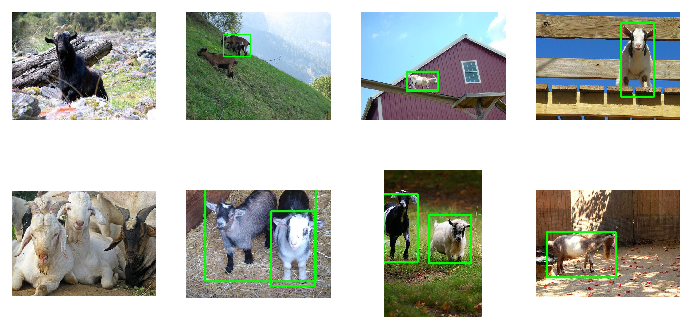

In [47]:
images = get_images(dest_dir, n=8)
show_images(images, 4, 2)